# MACHINE LEARNING TASKS ON EDGE DEVICES

 - This Notebook is used to train Machine Learning models
 - The code is partially borrowed from [LINK](https://machinelearningmastery.com/how-to-develop-a-cnn-from-scratch-for-cifar-10-photo-classification/)


# Import Libraries

In [1]:
#############################################################################
import os
import sys
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
#############################################################################
from utils import *
from models import *
#############################################################################

## define params

In [2]:
sys.argv = [
    'train.py',                
    '--cam',          'webcam',
    '--dataset',      'cifar10',
    '--model_name',   'custom',
    '--train_model',  'True',         
    '--epochs',       '50',               
    '--lr',           '0.005',                 
    '--batch_size',   '64',            
    '--path_models',  'models',    
    '--path_results', 'results',    
    '--verbose',      'True',
]

In [3]:
import argparse

parser = argparse.ArgumentParser()
parser.add_argument('--train_model',  type=bool,  default=True,     help='Set to True to train the model.')
parser.add_argument('--cam',          type=str,   default='webcam', help='Camera to be used.')
parser.add_argument('--dataset',      type=str,   default='cifar10',help='Camera to be used.')
parser.add_argument('--model_name',   type=str,   default='custom', help='Model to be used.')
parser.add_argument('--epochs',       type=int,   default=50,       help='Number of epochs for training.')
parser.add_argument('--lr',           type=float, default=0.005,    help='Learning rate for the optimizer.')
parser.add_argument('--batch_size',   type=int,   default=32,       help='Batch size for training.')
parser.add_argument('--path_models',  type=str,   required=True,    help='Path to tarined models.')
parser.add_argument('--path_results', type=str,   required=True,    help='Path to save/saved results.')
parser.add_argument('--verbose',      type=bool,  required=True,    help='show progress.')
args = parser.parse_args()

In [4]:
dataset_manager = DatasetManager(dataset_name='cifar10',preprocess_data=True)
trainX, trainY, testX, testY = dataset_manager.load_dataset(binary2multi=True)
class_names = dataset_manager.get_class_names()

## DEFINE/LOAD MODEL

In [5]:
# model = ms.define_model(args)
models = Models(args)
model = models.get_model()

c:\Users\XN2\miniconda3\envs\tfgpu\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


## Model Inspection

In [6]:
#### PRE TRAINING INSPECTION
inspector= Inspection(model)
inspector.model_stats()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 64)          0

### Train / Load Model

In [7]:
args.train_model = False
# args.train_model = True

In [8]:
csv_filepath = f'{args.path_models}/training_history_{args.epochs}_{args.lr}.csv'
model_filepath   = f'{args.path_models}/Resnet_pretrained_{args.epochs}_{args.lr}.keras'
if args.train_model:
    print('-'*100)
    print(f'training started for : | {args.epochs:<8} epochs &  learn_rate: {args.lr:<15} | & batch_size: {args.batch_size:<15} |')
    print('-'*100)
    history = model.fit(trainX, trainY, epochs=args.epochs, batch_size=args.batch_size, 
                    validation_data=(testX, testY), verbose=1)
    history_df = pd.DataFrame(history.history)
    history_df.to_csv(csv_filepath, index=False)
    model.save(model_filepath)
    print('-'*100)
    print(f'model trained and saved for :{args.epochs} epochs & learn_rate: {args.lr}')
    print('-'*100)
else:
    if os.path.exists(model_filepath):
        model = tf.keras.models.load_model(model_filepath)
        history_df = pd.read_csv(csv_filepath)
        print('-'*100)
        print(f'model loaded for :{args.epochs} epochs & learn_rate: {args.lr}')
        print('-'*100)
    else:
        print('-'*100)
        print(f'model not found :{args.epochs} epochs & learn_rate: {args.lr} ')
        print('-'*100)
        history_df = None

----------------------------------------------------------------------------------------------------
model loaded for :50 epochs & learn_rate: 0.005
----------------------------------------------------------------------------------------------------


In [9]:
#### POST TRAINING INSPECTION
inspector= Inspection(model)
inspector.model_stats(print_summary=False)

Trainable Parameters           550570
Non-Trainable Parameters       0.0
Total Parameters:              550570.0
Model Size (MB)                2.10
Approximate FLOPs              38.90 MFLOPs


## Test Model

In [10]:
_, acc = model.evaluate(testX, testY, verbose=args.verbose,  batch_size=8)

print('> %.3f' % (acc * 100.0))

1250/1250 [==============================] - 164s 91ms/step - loss: 0.6109 - accuracy: 0.8238
> 82.380


In [11]:
trainX, trainY, testX, testY = dataset_manager.load_dataset(binary2multi=False)

In [12]:
y_pred = model.predict(testX,verbose=args.verbose,  batch_size=8)
y_pred = np.argmax(y_pred, axis = 1).astype('uint8')

1250/1250 [==============================] - 29s 23ms/step


In [13]:
evaluation = Evaluation(y_true=testY,y_pred=y_pred)

In [14]:
results = evaluation.evaluate_model()

for perf_measures,perf_values in results.items():
    print(f'{perf_measures:<20} : {perf_values:<10.7}')

Accuracy             : 0.8238    
Balanced_Accuracy    : 0.8238    
Precision            : 0.8256042 
Recall               : 0.8238    
F1                   : 0.823831  
F_Beta               : 0.8246705 
cohen_kappa          : 0.8042222 
MCC                  : 0.8044089 


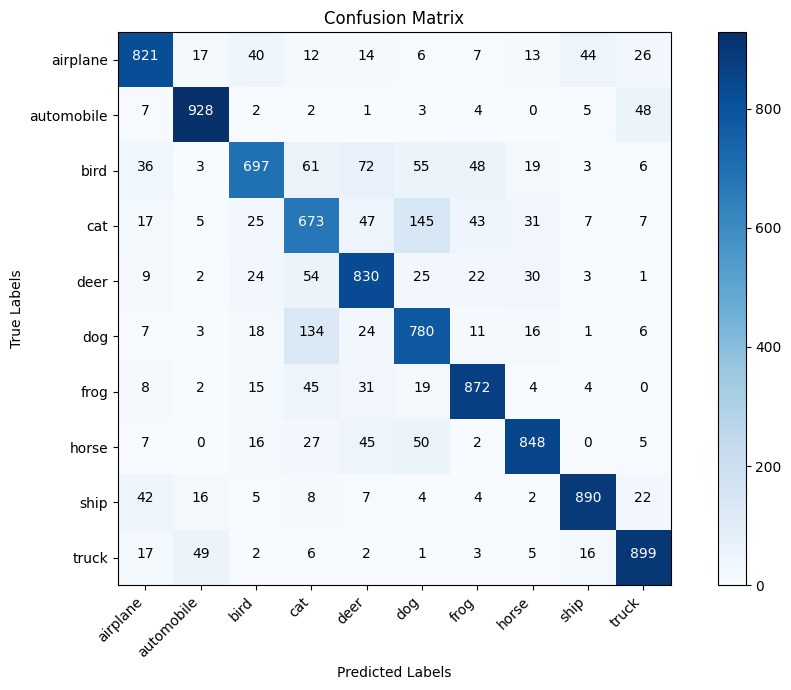

In [15]:
evaluation.plot_confusion_matrix()

## Convert Model to Tensorflow Lite and Save

In [16]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
open(f"{args.path_models}/converted_model_{args.epochs}_{args.lr}.tflite", "wb").write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\XN2\AppData\Local\Temp\tmptil2fm90\assets


2207544